X shape before reshape: torch.Size([1024, 3600])
cuda:0
Number of parameters: 104627
Memory size: 418508 bytes
Epoch: 1 | train_loss: 2.2845 | train_acc: 0.3712 | test_loss: 6.2832 | test_acc: 0.1951
Epoch: 2 | train_loss: 1.6535 | train_acc: 0.6386 | test_loss: 2.0012 | test_acc: 0.4146
Epoch: 3 | train_loss: 1.3053 | train_acc: 0.7387 | test_loss: 1.2981 | test_acc: 0.7220
Epoch: 4 | train_loss: 1.0877 | train_acc: 0.7668 | test_loss: 1.1694 | test_acc: 0.7366
Epoch: 5 | train_loss: 0.9270 | train_acc: 0.8266 | test_loss: 0.9764 | test_acc: 0.7951
Epoch: 6 | train_loss: 0.8720 | train_acc: 0.8168 | test_loss: 1.0779 | test_acc: 0.8195
Epoch: 7 | train_loss: 0.7955 | train_acc: 0.8291 | test_loss: 1.0046 | test_acc: 0.7610
Epoch: 8 | train_loss: 0.6566 | train_acc: 0.8620 | test_loss: 0.8422 | test_acc: 0.7707
Epoch: 9 | train_loss: 0.6329 | train_acc: 0.8608 | test_loss: 0.8134 | test_acc: 0.8195
Epoch: 10 | train_loss: 0.6970 | train_acc: 0.8462 | test_loss: 0.7531 | test_acc: 0.804

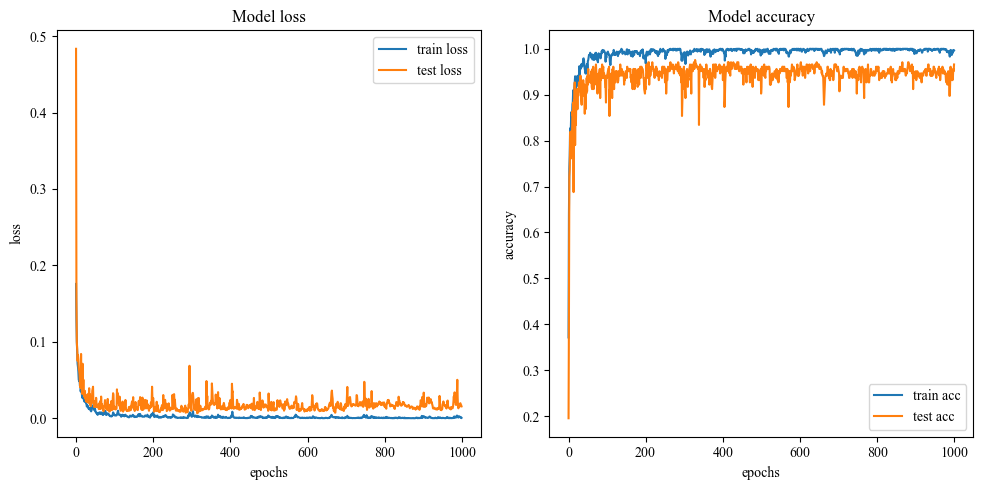

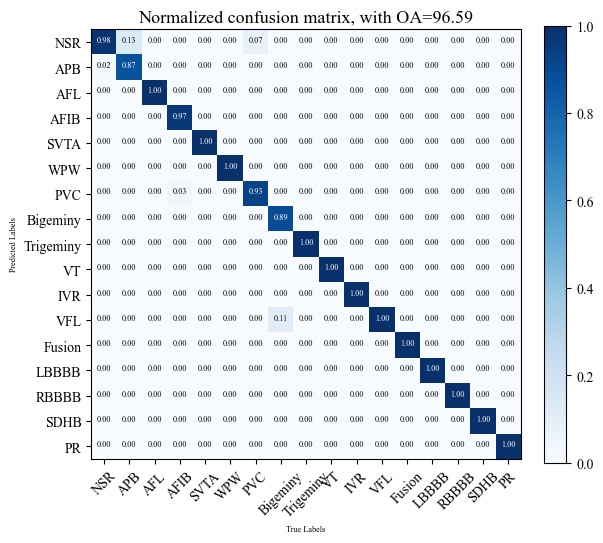

In [4]:
import os
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from matplotlib import pyplot as plt
from My_Basic_Net.utils.plot import plot_cfm
from My_Basic_Net.utils.Dataprocess import Loader

batch_size = 64
classes_num = 17
lr = 0.01
epochs = 1000
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
seed = 110
def set_seed(seed):
    # random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed) # if you are using multi-GPU.
    torch.backends.cudnn.benchmark = False
    torch.backends.cudnn.deterministic = True
set_seed(seed)

class FULL_conv_pool(nn.Module):
    def __init__(self, in_channels, out_channels, kernel_size, stride, padding, padding_value, pool_size,
                 pool_stride, ):
        super().__init__()
        self.in_channels = in_channels
        self.out_channels = out_channels
        self.kernel_size = kernel_size
        self.stride = stride
        self.padding = padding
        self.bn = nn.BatchNorm1d(out_channels)


        # pad
        self.pad = nn.ConstantPad1d(padding=padding, value=padding_value)
        # 无bias,一维卷积
        self.conv = nn.Conv1d(in_channels, out_channels, kernel_size=kernel_size, stride=stride, padding=padding)
        # MaxPool
        self.pool = nn.MaxPool1d(kernel_size=pool_size, stride=pool_stride)
        # ACT
        self.relu = nn.ReLU()
        self.prelu = nn.PReLU()
        self.tanh = nn.Tanh()
        self.htanh = nn.Hardtanh()
        # self.tanh = nn.Tanh()

    def forward(self, I):
        I = self.pad(I)
        I = self.conv(I)
        I = self.pool(I)
        I = self.prelu(I)
        I = self.bn(I)

        return I


class FULL_ECG(nn.Module):
    def __init__(self, device):
        super(FULL_ECG, self).__init__()
        self.name = 'FULL_ECG'
        self.device = device
        padding = 5
        pool_size = 5
        self.classifier = nn.Sequential(
        # input_channels, output_channels, kernel_size:335733, stride, padding7, pad_value, pool_size5, pool_stride
            FULL_conv_pool( 1, 8, 11, 1, padding, 1,
                            pool_size, 2),
            FULL_conv_pool( 8, 16, 11, 1, padding, 1,
                              pool_size, 2),
            FULL_conv_pool( 16, 32, 11, 1, padding, 1,
                              pool_size, 2),
            FULL_conv_pool(32, 64, 11, 1, padding, 1,
                             pool_size, 2),# 加一层
            FULL_conv_pool( 64, 72, 9, 1, padding, 1,
                              pool_size, 2),
            FULL_conv_pool(72, 32, 9, 1, padding, 1,
                             pool_size, 2),
            FULL_conv_pool(32, 32, 9, 1, padding, 1,
                           pool_size, 2),
            FULL_conv_pool(32, classes_num, 5, 1, padding, 1,
                       pool_size, 2)

        )

        self.dropout = nn.Dropout(p=0.5) # 防止过拟合

    def forward(self, batch_data):
        batch_data = batch_data.clone().detach().requires_grad_(True).to(self.device)
        batch_data = self.classifier(batch_data)
        batch_data = self.dropout(batch_data)
        batch_data = batch_data.mean(dim=2)  # 去掉一个维度

        return batch_data
loader = Loader(batch_size=batch_size, classes_num=classes_num, device=device, test_size=0.2)
labels, train_loader, test_loader = loader.loader()

model = FULL_ECG(device=device).to(device)

#####################################损失函数：交叉熵#########################################
loss_fn = nn.CrossEntropyLoss().to(device)

########################################优化器##############################################
# optimizer = torch.optim.SGD(model.parameters(), lr=lr)
optimizer = optim.Adam(model.parameters(), lr=lr)
# optimizer = optim.Adam(model.parameters(), lr=0.1)
# # scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=30, gamma=0.1)

print(device)
#################################学习率梯度衰减#################################
# 余弦退火
lr_scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=epochs, eta_min=0.05,last_epoch=-1)
print(f"Number of parameters: {sum(p.numel() for p in model.parameters())}")
print(f"Memory size: {sum(p.numel() * p.element_size() for p in model.parameters())} bytes")
results = {"train_loss": [],
           "train_acc": [],
           "test_loss": [],
           "test_acc": []
           }
best_test_acc = 0.0
best_train_acc = 0.0
best_test_epoch = 0
best_train_epoch = 0

# Make sure model on target device
model.to(device)

train_losses = []
train_acces = []
eval_losses = []
eval_acces = []
for epoch in range(epochs):
    ##################################开始训练########################################
    train_acc = 0
    train_loss = 0
    model.train()  # 将模型改为训练模式

    correct, total = 0, 0
    for X, y in train_loader:
        X, y = X.to(device), y.to(device)
        # 前向传播，得到损失
        y_pred = model(X)
        loss = loss_fn(y_pred, y)
        # 反向传播，将上一次的梯度清0，反向传播，并且step更新相应的参数
        optimizer.zero_grad()
        loss.backward()

        optimizer.step()


        # y_pred = BinarizeF.apply(y_pred)
        # 记录误差
        train_loss += loss.item()
        # 计算分类的准确率
        _, predicted = torch.max(y_pred.data, dim=1)  # 取出预测的最大值
        correct += (predicted == y).sum().cpu().item()  # 判断预测是否正确
        total += len(y)

    train_loss = train_loss / len(train_loader)
    train_acc = correct / total
    train_losses.append(train_loss / len(train_loader))
    train_acces.append(correct / total)

    ##########################每进行一次迭代，就去测试一次##################################
    model.eval()
    test_loss, test_acc = 0, 0
    correct, total = 0, 0

    with torch.inference_mode():
        for (X, y) in test_loader:
            X, y = X.to(device), y.to(device)
            test_pred_logits = model(X)

            loss = loss_fn(test_pred_logits, y)

            test_loss += loss.item()

            _, predicted = torch.max(test_pred_logits.data, dim=1)  # 输出概率最大的标签
            total += len(y)
            correct += (predicted == y).sum().cpu().item()  # 判断是否预测准确

    test_loss = test_loss / len(test_loader)
    test_acc = correct / total
    eval_losses.append(test_loss / len(train_loader))
    eval_acces.append(correct / total)

    if test_acc > best_test_acc:
        best_test_acc = test_acc
        best_test_epoch = epoch + 1
        acc_str = "{:.2f}".format(best_test_acc * 100) + '%'

    if train_acc > best_train_acc:
        best_train_acc = train_acc
        best_train_epoch = epoch + 1
        acc_str = "{:.2f}".format(best_test_acc * 100) + '%'

    print(
        f"Epoch: {epoch + 1} | "
        f"train_loss: {train_loss:.4f} | "
        f"train_acc: {train_acc:.4f} | "
        f"test_loss: {test_loss:.4f} | "
        f"test_acc: {test_acc:.4f}"
    )

    results["train_loss"].append(train_loss)
    results["train_acc"].append(train_acc)
    results["test_loss"].append(test_loss)
    results["test_acc"].append(test_acc)

# print(model.state_dict())
print('best_test_acc: ', "{:.2f}".format(best_test_acc * 100) + '%', '\t epoch: ', best_test_epoch)
print('best_train_acc: ', "{:.2f}".format(best_train_acc * 100) + '%', '\t epoch: ', best_train_epoch)
print("-" * 50 + "\n")
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.plot(np.arange(len(train_losses)), train_losses, label="train loss")
plt.plot(np.arange(len(eval_losses)), eval_losses, label="test loss")
plt.legend()
plt.xlabel('epochs')
plt.ylabel('loss')
plt.title('Model loss')

plt.subplot(1, 2, 2)
plt.plot(np.arange(len(train_acces)), train_acces, label="train acc")
plt.plot(np.arange(len(eval_acces)), eval_acces, label="test acc")
plt.legend()
plt.xlabel('epochs')
plt.ylabel('accuracy')
plt.title('Model accuracy')

plot_cfm(model, test_loader, classes=labels, mode='full_test', cnt=1000, clt=classes_num)

AttributeError: 'NoneType' object has no attribute 'dpi_scale_trans'

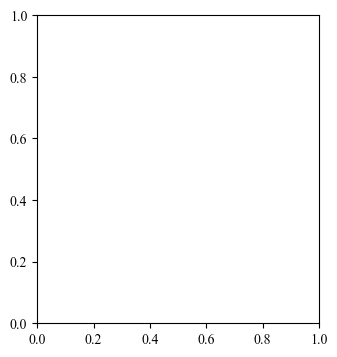

In [8]:
x = np.arange(1, epochs + 1)
fig, ax = plt.subplots(figsize=(8, 4))
plt.subplot(1, 2, 2)
ax.plot(x, results['train_loss'], color='red', label='Train Loss')
ax.plot(x, results['test_loss'], color='blue', label='Test Loss')
plt.subplot(1, 2, 2)
ax.plot(x, results['train_acc'], color='green', label='Train Accuracy')
ax.plot(x, results['test_acc'], color='purple', label='Test Accuracy')
ax.set_title('Training and Testing Metrics')
ax.set_xlabel('Epoch')
ax.set_ylabel('Metrics')
ax.legend(loc='best')
plt.show()

In [7]:
from torchinfo import summary

summary(model=model,
        input_size=(batch_size, 1, 3600),  # make sure this is "input_size", not "input_shape"
        col_names=["input_size", "output_size", "num_params", "trainable"],
        col_width=20,
        row_settings=["var_names"])

Layer (type (var_name))                  Input Shape          Output Shape         Param #              Trainable
FULL_ECG (FULL_ECG)                      [64, 1, 3600]        [64, 17]             --                   True
├─Sequential (classifier)                [64, 1, 3600]        [64, 17, 24]         --                   True
│    └─FULL_conv_pool (0)                [64, 1, 3600]        [64, 8, 1803]        --                   True
│    │    └─ConstantPad1d (pad)          [64, 1, 3600]        [64, 1, 3610]        --                   --
│    │    └─Conv1d (conv)                [64, 1, 3610]        [64, 8, 3610]        96                   True
│    │    └─MaxPool1d (pool)             [64, 8, 3610]        [64, 8, 1803]        --                   --
│    │    └─PReLU (prelu)                [64, 8, 1803]        [64, 8, 1803]        1                    True
│    │    └─BatchNorm1d (bn)             [64, 8, 1803]        [64, 8, 1803]        16                   True
│    └─FULL_conv_p